In [98]:
from IPython.display import display
from dataclasses import dataclass
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None

from elarb.policy import (
    optimal_policy, PolicyInput, PolicyOutput
)
from elarb.models import (
    SolarPanel,
    Battery,
    GridConnection,
    Inverter,
)
from elarb import datasets

In [25]:
n_panels = widgets.IntSlider(value=100, min=0, max=200, description='Solar panels:', continuous_update=True)
n_inverters = widgets.IntSlider(value=3, min=0, max=10, description='Inverters:', continuous_update=True)
n_batteries = widgets.IntSlider(value=9, min=0, max=10, description='Batteries:', continuous_update=True)
stikledning_amp = widgets.IntSlider(value=63.0, min=0, max=100, description='Ampere:', continuous_update=True)
stikledning_volt = widgets.IntSlider(value=400, min=0, max=500, description='Volt:', continuous_update=True)

## Load data

In [26]:
df_nordpool = pd.read_csv('../data/nordpool_21_22.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
df_nordpool.head(3)

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2020-12-31 23:00:00,2021-01-01 00:00:00,DK2,378.519989,50.869999,2021-01-01,0
1,2021-01-01 00:00:00,2021-01-01 01:00:00,DK2,358.579987,48.189999,2021-01-01,1
2,2021-01-01 01:00:00,2021-01-01 02:00:00,DK2,332.459991,44.680000,2021-01-01,2


In [27]:
year = 2021
df = df_nordpool[(df_nordpool.HourDK.dt.year == year)]
date = df.sample(n=1).iloc[0, :]

In [39]:
def sample_period(df, year):
    df = df[(df.HourDK.dt.year == year)]
    sample_date = df.iloc[:-1, :].sample(n=1).iloc[0, :]
    today = sample_date.HourDK.date()
    tomorrow = today + datetime.timedelta(days=1)
    df = df[df.HourDK.dt.date.isin([today, tomorrow])].sort_values(by='HourDK')
    return df.iloc[12:, :] # from noon

In [29]:
df_pv = pd.read_csv('../data/pvwatts.csv')

In [30]:
def filter_pv(df_pv, df_nordpool):
    ts0 = df_nordpool.HourDK.min()
    ts1 = df_nordpool.HourDK.max()
    idx0 = df_pv[(df_pv.Month == ts0.month) & (df_pv.Day == ts0.day) & (df_pv.Hour == ts0.hour)].index[0]
    idx1 = df_pv[(df_pv.Month == ts1.month) & (df_pv.Day == ts1.day) & (df_pv.Hour == ts1.hour)].index[0]+1
    df_pv_win = df_pv[idx0:idx1].reset_index().copy()
    return df_pv_win

In [40]:
# example
sample_nordpool = sample_period(df_nordpool, year=2022)
sample_pv = filter_pv(df_pv, sample_nordpool)

## Configure and optimise

In [41]:
BIGNUM = 100

In [42]:
display(n_panels)
display(n_inverters)
display(n_batteries)
display(stikledning_amp)
display(stikledning_volt)

IntSlider(value=100, description='Solar panels:', max=200)

IntSlider(value=3, description='Inverters:', max=10)

IntSlider(value=9, description='Batteries:', max=10)

IntSlider(value=63, description='Ampere:')

IntSlider(value=400, description='Volt:', max=500)

In [43]:
# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time, costs 1565 DKK
panel = SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
# DK grid
grid = GridConnection(throughput_kWh=stikledning_amp.value * stikledning_volt.value / 1000)
# Deye SUN-12K-SG04LP3-EU
inverter = Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03,)
# battery: Powerwall LBATTS Powerwall, 8.8 kwh
battery = Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03,)
print(panel)
print(grid)
print(inverter)
print(battery)

SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
GridConnection(throughput_kWh=25.2)
Inverter(throughput_kWh=15.6, depreciation_per_hour=0.0, conversion_loss_pct=0.03)
Battery(capacity_kWh=8.8, throughput_kWh=3.3, conversion_loss_pct=0.03, depreciation_per_kWh=0.398)


In [92]:
@dataclass
class Sample:
    ts: np.ndarray
    spot_dkk: np.ndarray
    pv_kWh: np.ndarray
    result: PolicyOutput

def sample_obj(df_pv, df_nordpool, year, n=1000):
    i = 0
    while i<n:
        try:
            sample_nordpool = sample_period(df_nordpool, year=year)
            sample_pv = filter_pv(df_pv, sample_nordpool)
            BIGNUM = 1000

            n_hours = len(sample_nordpool)
            spot_price=sample_nordpool.SpotPriceDKK.values/1000
            pv_kWh = sample_pv['AC System Output (W)'].values / 1000

            policy_input = PolicyInput(
                pv_kWh=pv_kWh,
                spot_price=spot_price,
                spot_demand_kWh=np.zeros(n_hours) + BIGNUM,
                spot_supply_kWh=np.zeros(n_hours) + BIGNUM,
                panel=panel,
                battery=battery,
                inverter=inverter,
                grid=grid,
                n_panels=n_panels.value,
                n_batteries=n_batteries.value,
                n_inverters=n_inverters.value,
                initial_soc=0.0
            )
            res = optimal_policy(policy_input)
            yield Sample(
                ts=sample_nordpool.HourDK, 
                spot_dkk=sample_nordpool.SpotPriceDKK,
                pv_kWh=pv_kWh,
                result=res
            )
            i += 1
        except:
            continue

In [104]:
n_samples = 500
samp2021 = np.array(list(sample_obj(df_pv, df_nordpool, 2021, n=n_samples)))
samp2022 = np.array(list(sample_obj(df_pv, df_nordpool, 2022, n=n_samples)))
samp = np.concatenate([samp2021, samp2022])

df_samp = pd.DataFrame({
    'year': [o.ts.min().year for o in samp],
    'start_ts': [o.ts.min() for o in samp],
    'end_ts': [o.ts.max() for o in samp],
    'yield': [o.result.value for o in samp],
    'yield_x1': [o.result.x1_contrib for o in samp],
    'yield_x2': [o.result.x2_contrib for o in samp],
    'yield_x3': [o.result.x3_contrib for o in samp],
    'yield_x4': [o.result.x4_contrib for o in samp],
    'kWh': [o.result.x1.sum()+o.result.x3.sum() for o in samp],
    'kWh_x1': [o.result.x1.sum() for o in samp],
    'kWh_x2': [o.result.x2.sum() for o in samp],
    'kWh_x3': [o.result.x3.sum() for o in samp],
    'kWh_x4': [o.result.x4.sum() for o in samp],
    'depr_panel': [o.result.panel_depreciation for o in samp],
    'depr_battery': [o.result.battery_depreciation for o in samp],
    'n_panel': [n_panels.value for _ in range(len(samp))],
    'n_battery': [n_batteries.value for _ in range(len(samp))],
    'grid_amp': [stikledning_amp.value for _ in range(len(samp))],
    'grid_volt': [stikledning_volt.value for _ in range(len(samp))],
    'spot_min': [o.spot_dkk.min() for o in samp],
    'spot_max': [o.spot_dkk.max() for o in samp],
    'spot_mean': [o.spot_dkk.mean() for o in samp],
    'spot_std': [o.spot_dkk.std() for o in samp],
    'pv_kWh_min': [o.pv_kWh.min() for o in samp],
    'pv_kWh_max': [o.pv_kWh.max() for o in samp],
    'pv_kWh_mean': [o.pv_kWh.mean() for o in samp],
    'pv_kWh_std': [o.pv_kWh.std() for o in samp],    
}).round(2)
df_samp.to_csv('../data/simulation_21_22.csv.csv', index=False)
print(len(df_samp))
df_samp

1000


,year,start_ts,end_ts,yield,yield_x1,yield_x2,yield_x3,yield_x4,kWh,kWh_x1,kWh_x2,kWh_x3,kWh_x4,depr_panel,depr_battery,n_panel,n_battery,grid_amp,grid_volt,spot_min,spot_max,spot_mean,spot_std,pv_kWh_min,pv_kWh_max,pv_kWh_mean,pv_kWh_std
0,2021,2021-12-08 12:00:00,2021-12-09 23:00:00,123.49,28.81,0.0,260.91,-103.44,117.50,13.10,4.19,104.40,103.43,21.24,41.55,100,9,63,400,847.79,2644.95,1787.03,665.14,0.0,0.07,0.01,0.01
1,2021,2021-04-11 12:00:00,2021-04-12 23:00:00,114.52,134.02,0.0,17.36,-0.00,397.04,357.77,51.59,39.26,0.00,21.24,15.63,100,9,63,400,152.75,540.36,341.00,105.05,0.0,0.62,0.18,0.22
2,2021,2021-06-07 12:00:00,2021-06-08 23:00:00,267.29,245.37,0.0,105.80,-0.00,579.03,421.62,162.27,157.41,0.00,21.24,62.65,100,9,63,400,450.96,738.61,584.58,74.55,0.0,0.69,0.23,0.25
3,2021,2021-05-03 12:00:00,2021-05-04 23:00:00,127.01,134.17,0.0,44.47,-0.00,485.96,409.58,116.29,76.37,0.00,21.24,30.40,100,9,63,400,208.89,592.73,348.32,98.54,0.0,0.83,0.27,0.32
4,2021,2021-01-06 12:00:00,2021-01-07 23:00:00,-8.45,10.39,0.0,18.74,-6.32,47.54,22.34,0.00,25.20,25.98,21.24,10.03,100,9,63,400,241.74,743.83,456.95,143.04,0.0,0.07,0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022,2022-04-16 12:00:00,2022-04-17 23:00:00,275.79,139.47,0.0,226.24,-5.64,474.17,315.78,143.89,158.40,19.41,21.24,63.04,100,9,63,400,97.74,1530.91,856.75,465.51,0.0,0.74,0.17,0.22
996,2022,2022-02-27 12:00:00,2022-02-28 23:00:00,216.94,78.91,0.0,438.35,-185.99,300.83,66.93,52.15,233.90,188.98,21.24,93.09,100,9,63,400,831.01,2402.69,1338.82,408.98,0.0,0.29,0.04,0.08
997,2022,2022-05-06 12:00:00,2022-05-07 23:00:00,689.58,516.65,0.0,270.37,-14.65,518.27,363.62,148.92,154.64,10.50,21.24,61.55,100,9,63,400,1184.19,1954.45,1526.96,175.87,0.0,0.83,0.23,0.29
998,2022,2022-07-05 12:00:00,2022-07-06 23:00:00,1042.45,798.43,0.0,328.29,-0.00,592.94,434.56,163.27,158.37,0.00,21.24,63.03,100,9,63,400,271.01,3079.04,1817.35,511.67,0.0,0.82,0.28,0.31


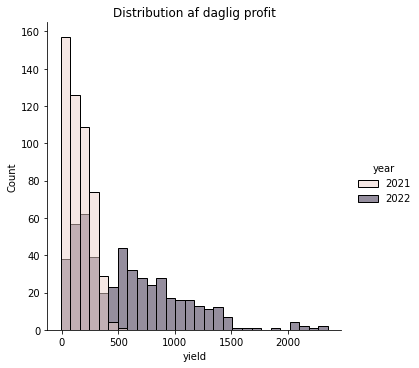

In [95]:
sns.displot(data=df_samp, x='yield', hue='year')
plt.title('Distribution af daglig profit')
plt.show()

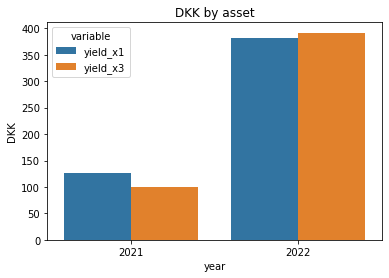

In [117]:
cols = ['year', 'yield_x1', 'yield_x3']
df_plot = df_samp.groupby('year').mean().reset_index().loc[:, cols].melt(id_vars='year')
sns.barplot(data=df_plot, x='year', y='value', hue='variable')
plt.ylabel('DKK')
plt.title('DKK by asset')
plt.show()
#df_plot

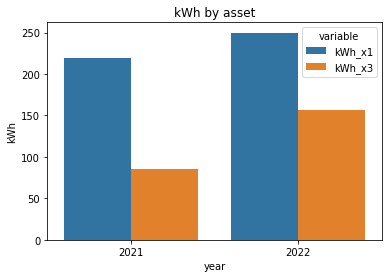

In [120]:
cols = ['year', 'kWh_x1', 'kWh_x3']
df_plot = df_samp.groupby('year').mean().reset_index().loc[:, cols].melt(id_vars='year')
sns.barplot(data=df_plot, x='year', y='value', hue='variable')
plt.ylabel('kWh')
plt.title('kWh by asset')
plt.show()
#df_plot

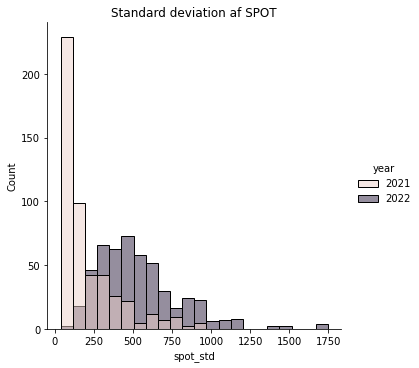

In [122]:
sns.displot(data=df_samp, x='spot_std', hue='year')
plt.title('Standard deviation af SPOT')
plt.show()

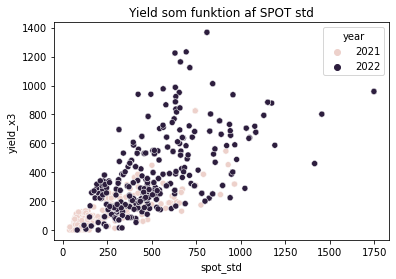

In [128]:
sns.scatterplot(data=df_samp, x='spot_std', y='yield_x3', hue='year')
plt.title('Yield som funktion af SPOT std')
plt.show()

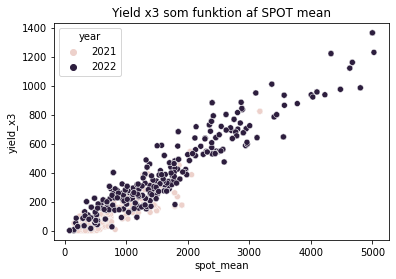

In [132]:
sns.scatterplot(data=df_samp, x='spot_mean', y='yield_x3', hue='year')
plt.title('Yield x3 som funktion af SPOT mean')
plt.show()

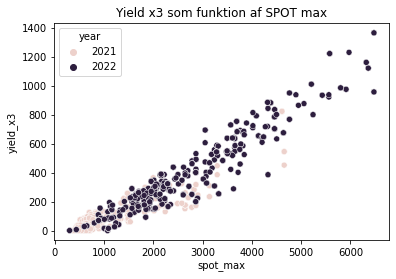

In [133]:
sns.scatterplot(data=df_samp, x='spot_max', y='yield_x3', hue='year')
plt.title('Yield x3 som funktion af SPOT max')
plt.show()

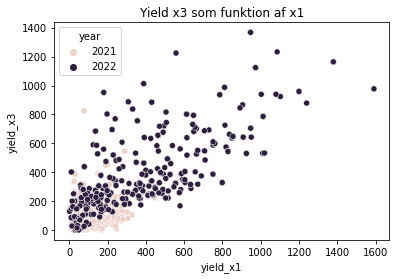

In [134]:
sns.scatterplot(data=df_samp, x='yield_x1', y='yield_x3', hue='year')
plt.title('Yield x3 som funktion af x1')
plt.show()

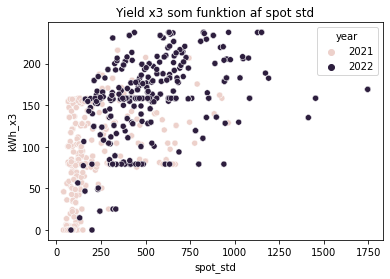

In [152]:
sns.scatterplot(data=df_samp, x='spot_std', y='kWh_x3', hue='year')
plt.title('Yield x3 som funktion af spot std')
plt.show()

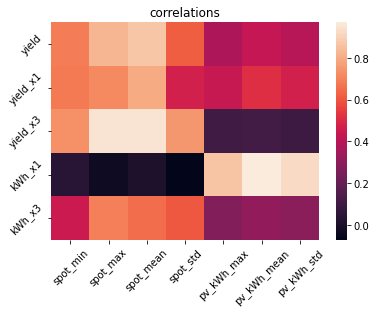

In [149]:
rows = ['yield', 'yield_x1', 'yield_x3', 'kWh_x1', 'kWh_x3']
cols = ['spot_min', 'spot_max', 'spot_mean', 'spot_std', 'pv_kWh_max', 'pv_kWh_mean', 'pv_kWh_std',]
sns.heatmap(df_samp.corr().loc[rows, cols])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('correlations')
plt.show()